<a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/SMT_MixedInteger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="jumbotron text-left"><b>
    
This tutorial describes how to perform a mixed optimization using the SMT toolbox. The idea is to use a Bayesian Optimization (EGO method) to solve an unconstrained optimization problem with mixed variables.
<div>
    
    May 2024 - version SMT 2.5.1 
  
    Paul Saves and Nathalie BARTOLI (ONERA/DTIS/M2CI)

<div class="alert alert-info fade in" id="d110">
<p>Some updates</p>
<ol> -  EGO applied to mixed integer problems (1D, 2D and 4D) using continuous relaxation </ol>
<ol> -  Manipulation of mixed integer DOE </ol>
<ol> -  Gower distance to build surrogate model  of mixed integer functions (2D and 4D) </ol>    
<ol> -  EGO applied to mixed integer problems (4D) using Gower distance </ol>
<ol> -  EGO applied to mixed integer problems using Homoscedastic or  Heteroscedastic kernel </ol>   
</div>

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference paper is available 
here https://www.sciencedirect.com/science/article/pii/S0965997818309360?via%3Dihub 

or as a preprint: http://mdolab.engin.umich.edu/content/python-surrogate-modeling-framework-derivatives

For mixed integer with continuous relaxation, the reference paper is available here https://www.sciencedirect.com/science/article/pii/S0925231219315619

### Mixed Integer EGO

For mixed integer EGO, the model is the continuous one. The discrete variables being relaxed continuously

In [1]:
#to install smt
!pip install smt

<div class="alert alert-warning" >
If you use hierarchical variables and the size of your doe greater than 30 points, you may leverage the `numba` JIT compiler to speed up the computation
To do so:
    
 - install numba library
    
     `pip install numba`
    
    
 - and define the environment variable `USE_NUMBA_JIT = 1` (unset or 0 if you do not want to use numba) 
    
     - Linux: export USE_NUMBA_JIT = 1
    
     - Windows: set USE_NUMBA_JIT = 1

</div>

In [2]:
#to check if numba is available
!pip show numba
#and then you need to define the environment variable USE_NUMBA_JIT
!echo "Numba used or not in your environment=" %USE_NUMBA_JIT%

Name: numba
Version: 0.57.1
Summary: compiling Python code using LLVM
Home-page: https://numba.pydata.org
Author: 
Author-email: 
License: BSD
Location: D:\bartoli\anaconda3\Lib\site-packages
Requires: llvmlite, numpy
Required-by: datashader
"Numba used or not in your environment=" 0


In [3]:
%matplotlib inline  

from math import exp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.optimize import minimize
import scipy
import six
from smt.applications import EGO
from smt.surrogate_models import KRG
from smt.sampling_methods import FullFactorial
from smt.sampling_methods import LHS
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import matplotlib.font_manager


from smt.surrogate_models import MixIntKernelType
from smt.applications.mixed_integer import MixedIntegerKrigingModel

#to ignore warning messages
import warnings
warnings.filterwarnings("ignore")

from smt.applications.mixed_integer import MixedIntegerSamplingMethod


from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    IntegerVariable,
    OrdinalVariable,
    CategoricalVariable,
)


Definition of the plot function 

In [4]:

def PlotEgo(criterion, xdoe, bounds,npt,n_iter,sm) :
    ego = EGO(n_iter=n_iter, criterion=criterion, xdoe=xdoe, n_start=20,n_max_optim=35,enable_tunneling=False, surrogate=sm)
    x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=f)
    print("Minimum in x={:.0f} with f(x)={:.10f}".format(int(x_opt), float(y_opt)))

    x_plot = np.atleast_2d(np.linspace(bounds[0][0], bounds[0][1], 9*(npt-1)+1)).T
    fig = plt.figure(figsize=[15, 15])
    for i in range(n_iter):
        k = n_doe + i
        x_data_k = x_data[0:k]
        y_data_k = y_data[0:k]
        
            #if check list, not already evaluated
        y_data[k]=f(x_data[k][:, np.newaxis])
        ego.gpr.set_training_values(x_data_k, y_data_k)
        ego.gpr.train()
        y_gp_plot = ego.gpr.predict_values(x_plot)
        y_gp_plot_var = ego.gpr.predict_variances(x_plot)
        y_ei_plot = ego.EI(x_plot,False)
        ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
        ax1 = ax.twinx()
        ei, = ax1.plot(x_plot, y_ei_plot, color="red")

        true_fun = ax.scatter(Xsol, Ysol,color='k',marker='d')
        data, = ax.plot(
            x_data_k, y_data_k, linestyle="", marker="o", color="orange"
        )
        if i < n_iter - 1:
            opt, = ax.plot(
                x_data[k], y_data[k], linestyle="", marker="*", color="r"
            )
            print(x_data[k], y_data[k])
        gp, = ax.plot(x_plot, y_gp_plot, linestyle="--", color="g")        
        sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
        sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
        un_gp = ax.fill_between(
            x_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
        )
        lines = [true_fun, data, gp, un_gp, opt, ei]
        fig.suptitle("EGO optimization of a set of points")
        fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
        ax.set_title("iteration {}".format(i + 1))
        fig.legend(
            lines,
            [
                "set of points",
                "Given data points",
                "Kriging prediction",
                "Kriging 99% confidence interval",
                "Next point to evaluate",
                "Expected improvment function",
            ],
        )
    plt.show()

## Local minimum trap: 1D function 
 The 1D function to optimize is described by: 
- 1 discrete variable $\in [0, 25]$

In [5]:
#definition of the 1D function
def f(X) :
    x= X[:, 0]
    if (np.abs(np.linalg.norm(np.floor(x))-np.linalg.norm(x))< 0.000001):
        y = (x - 3.5) * np.sin((x - 3.5) / (np.pi))
    else :
        print("error")
    return y

Min of the DOE:  -15.121611536143384


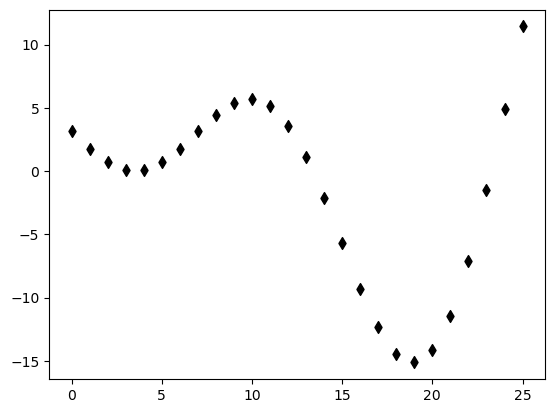

In [6]:
#to plot the function
bounds = np.array([[0, 25]])
npt=26

Xsol = np.linspace(bounds[0][0],bounds[0][1], npt)
Xs= Xsol[:, np.newaxis]
Ysol = f(Xs)
print("Min of the DOE: ",np.min(Ysol)) 
plt.scatter(Xs,Ysol,marker='d',color='k')
plt.show()

Minimum in x=19 with f(x)=-15.1216115361
[1.] [1.78601478]
[4.] [0.07924194]
[23.] [-1.48334497]
[20.] [-14.15453288]
[17.] [-12.35295142]
[19.] [-15.12161154]
[19.] [-15.12161154]
[14.] [-2.09283123]
[5.] [0.68929352]


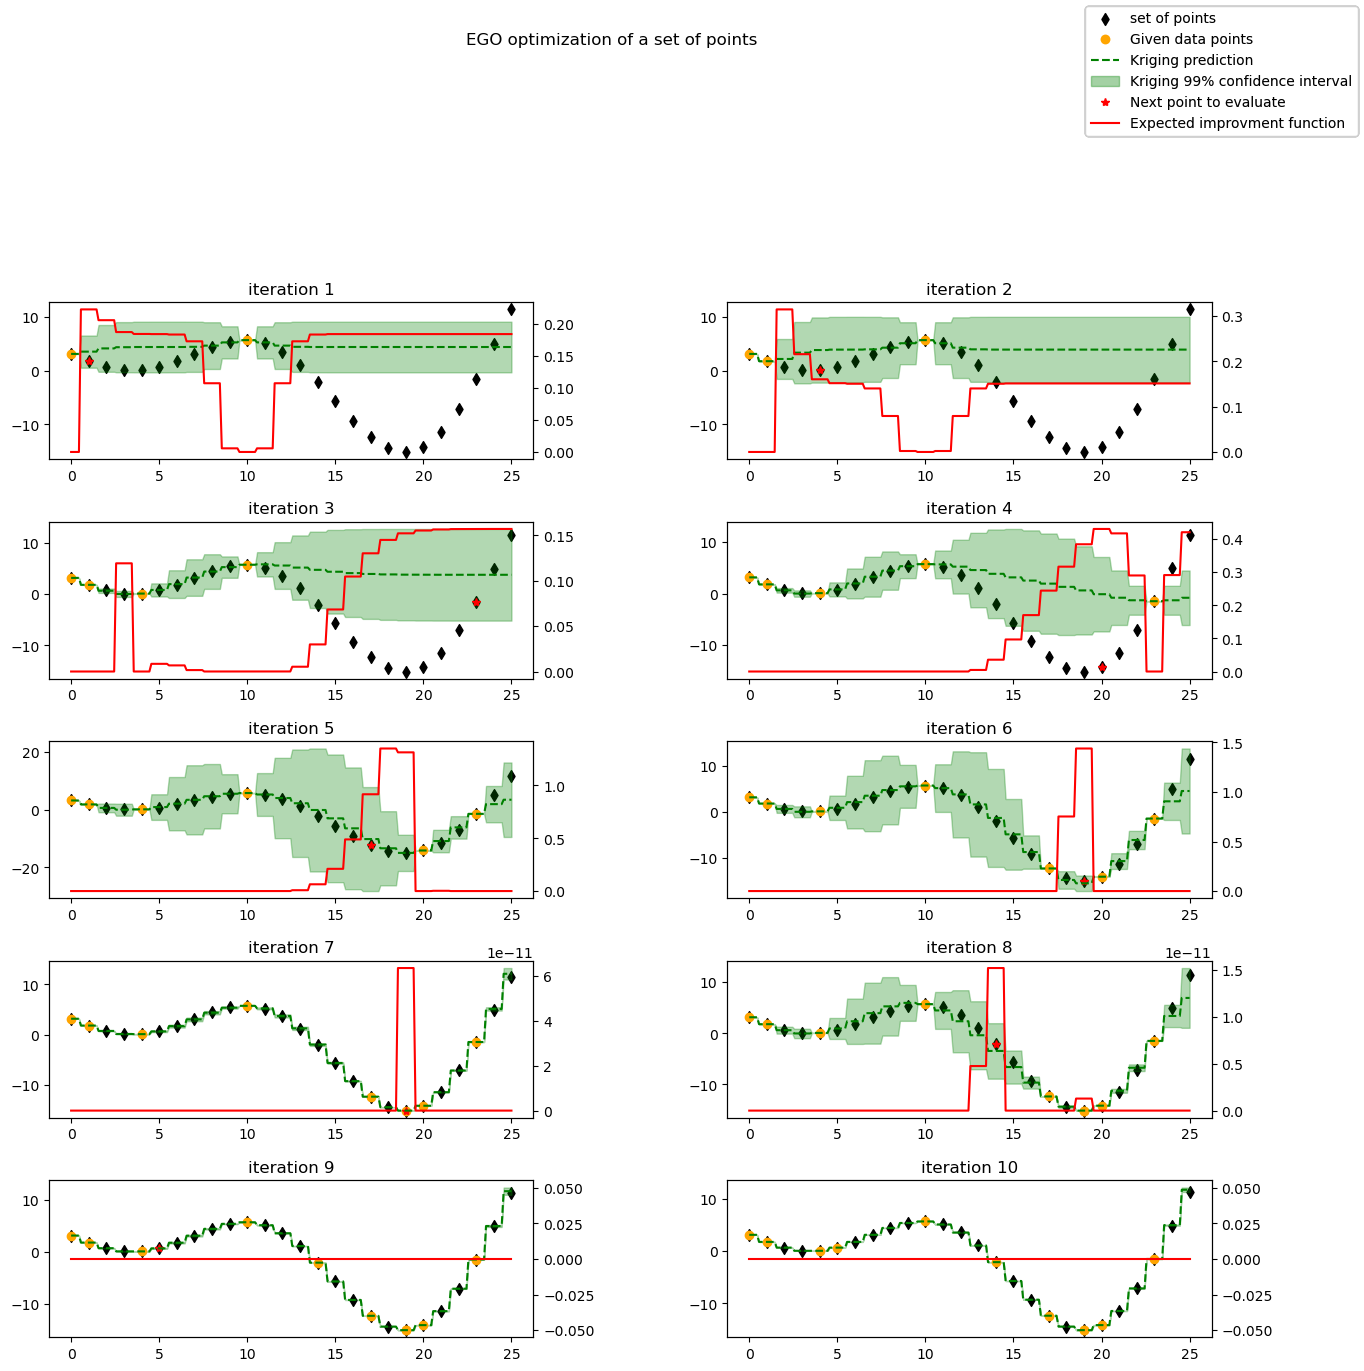

In [7]:
#to run the optimization process
n_iter = 10
xdoe = np.atleast_2d([0,10]).T
n_doe = xdoe.size
design_space = DesignSpace([
    IntegerVariable(bounds[0][0],bounds[0][1])])
    
criterion = "EI"  #'EI' or 'SBO' or 'LCB'

sm=KRG(design_space=design_space, print_global=False) #default kernel = Continuous relaxation 
PlotEgo(criterion,xdoe,bounds,npt,n_iter,sm)


On this 1D test case, 10 iterations are required to find the global minimum, evaluated at iteration 8.

### To choose a LHS sampling and the categorical kernel before running EGO

Minimum in x=19 with f(x)=-15.1216115361
[16.] [-9.28531859]
[0.] [3.14127616]
[18.] [-14.43198471]
[4.] [0.07924194]
[20.] [-14.15453288]
[12.] [3.58937619]
[19.] [-15.12161154]
[13.] [1.11508646]
[0.] [3.14127616]


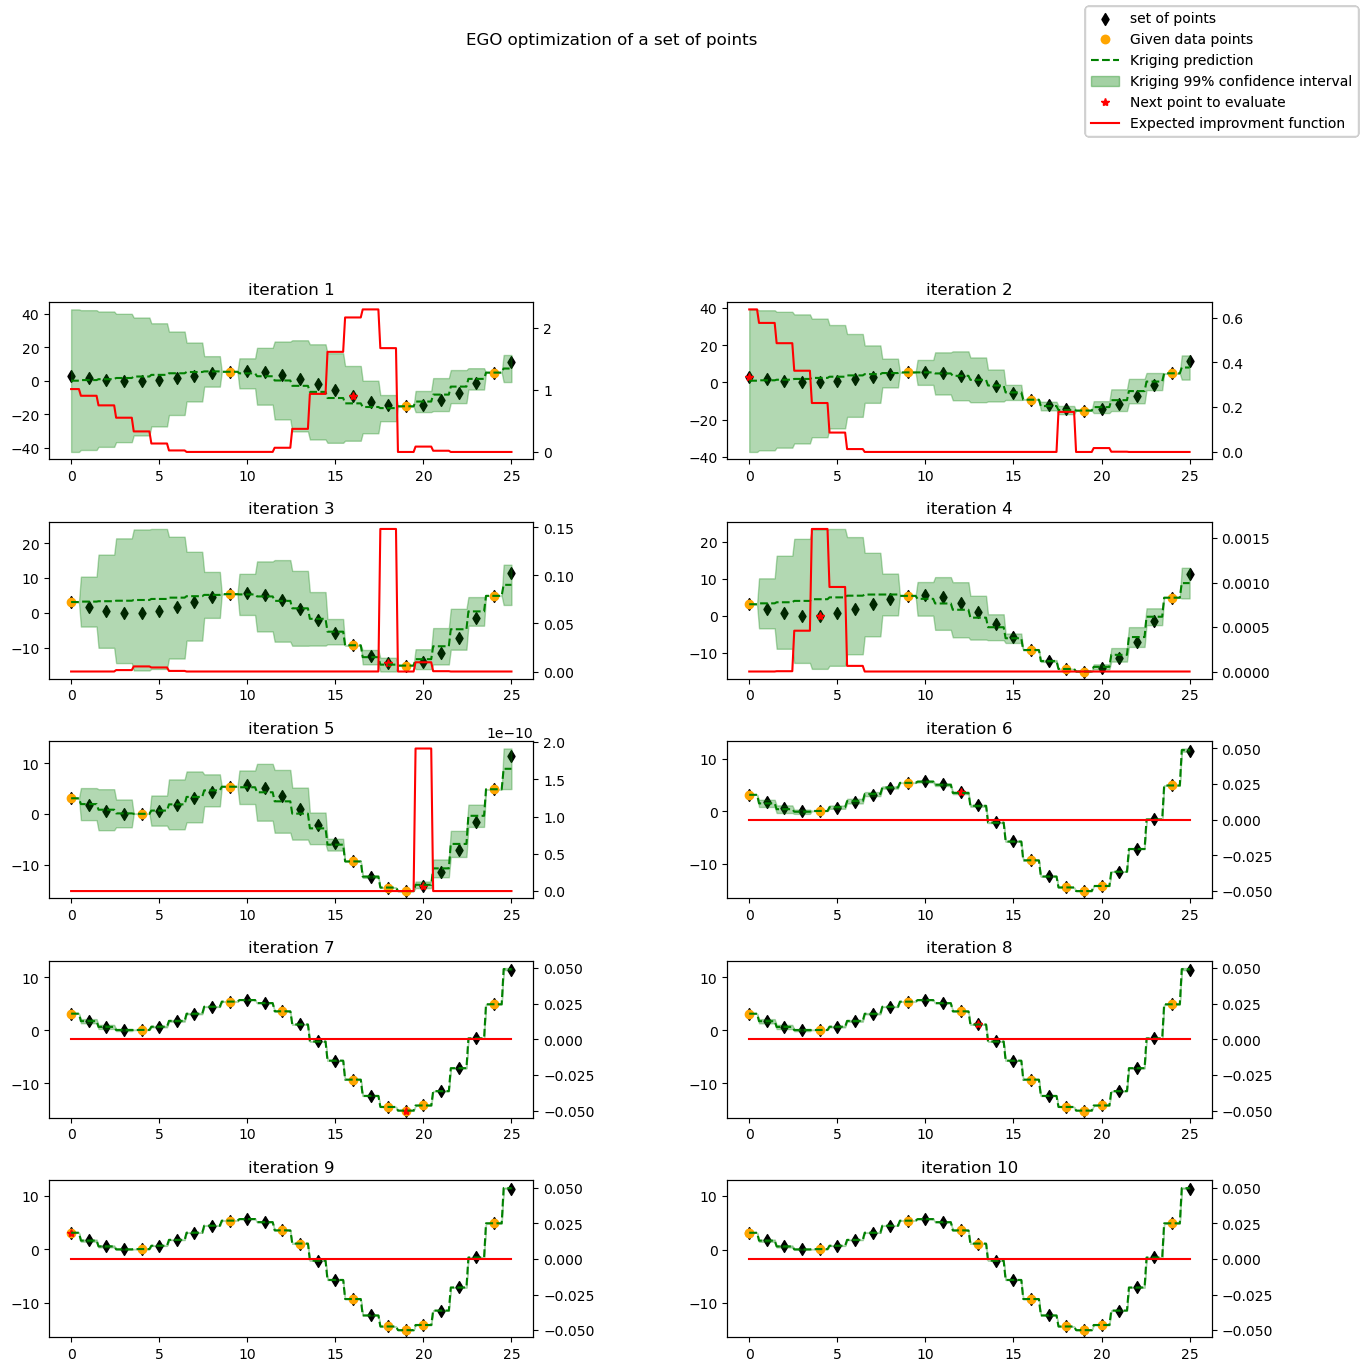

In [8]:
#to build a LHS sampling and choose the kernel
n_doe = 3
design_space = DesignSpace([
    IntegerVariable(bounds[0][0],bounds[0][1])])

sampling = MixedIntegerSamplingMethod(LHS,design_space, criterion="ese", random_state=42)

xdoe = sampling(n_doe)

criterion = "EI"  #'EI' or 'SBO' or 'LCB'
sm=KRG(design_space=design_space, print_global=False, categorical_kernel=MixIntKernelType.GOWER)
PlotEgo(criterion,xdoe,bounds,npt,n_iter,sm=sm)

On this 1D test case, 10 iterations are required to find the global minimum, evaluated at iteration 3.

 ## 1D function with noisy values
 The 1D function to optimize is described by: 
- 1 discrete variable $\in [0, 60]$

In [9]:
def f(X) :
    x= X[:, 0]
    y = -np.square(x-25)/220+0.25*(np.sin((x - 3.5) * np.sin((x - 3.5) / (np.pi)))+np.cos(x**2))
    np.random.seed(10)
    y2 = y+3*np.random.uniform(size=y.shape)
    return -y2

min of the DOE:  -2.6466034697899508


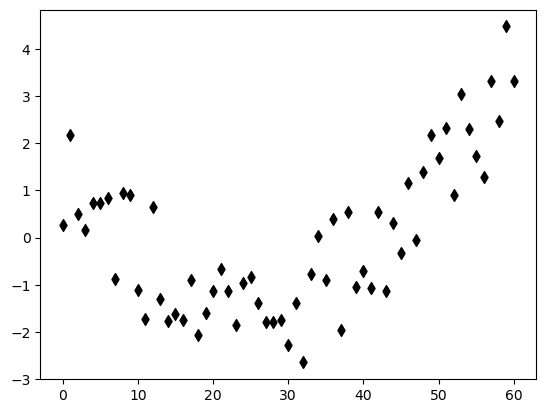

In [10]:
#to plot the function
xlimits = np.array([[0, 60]])
npt=61

Xsol = np.linspace(xlimits[0][0],xlimits[0][1], npt)
Xs= Xsol[:, np.newaxis]
Ysol = f(Xs)

print("min of the DOE: ", np.min(Ysol))
plt.scatter(Xs,Ysol,marker='d',color='k')
plt.show()

Minimum in x=15 with f(x)=-2.0881133575
[11.] [-1.18295021]
[0.] [0.27686804]
[16.] [-1.90108048]
[18.] [-1.62333834]
[5.] [-0.90257885]
[15.] [-2.08811336]
[15.] [-2.08811336]
[14.] [-1.63287697]
[20.] [-1.81903918]


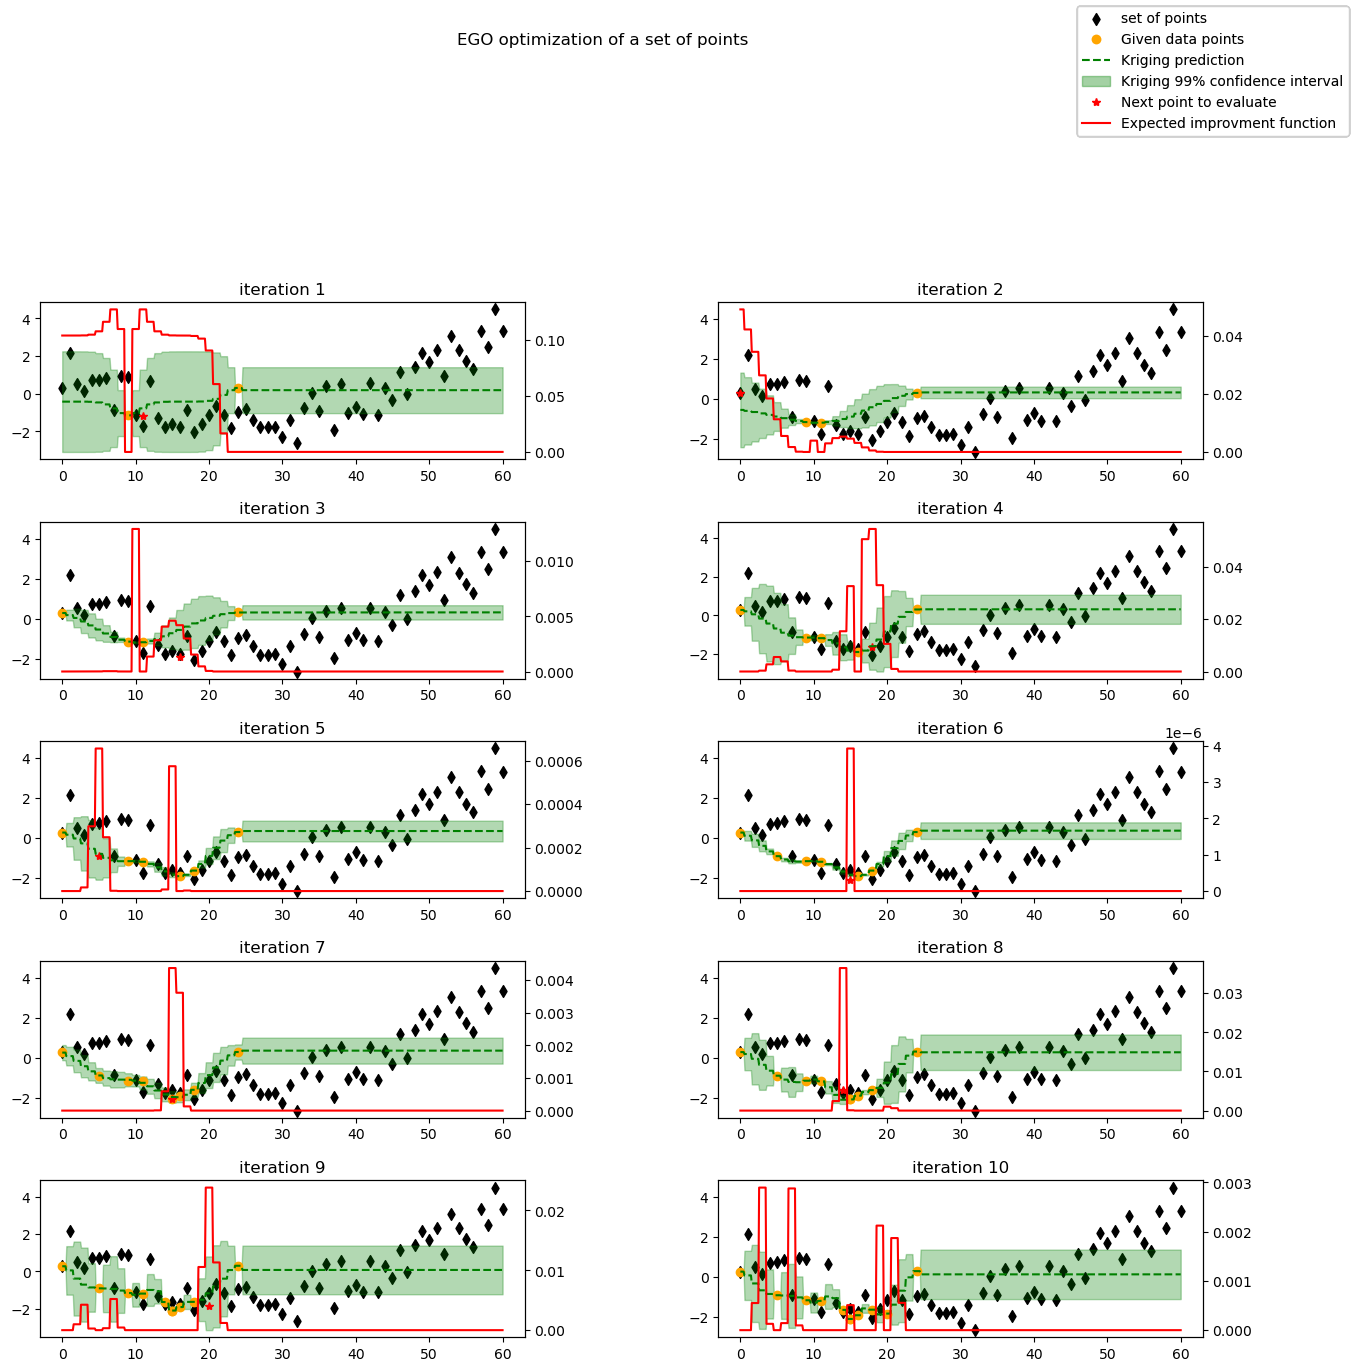

In [11]:
#to run the optimization process
n_iter = 10
n_doe=2

design_space = DesignSpace([
    IntegerVariable(bounds[0][0],bounds[0][1])])

sampling = MixedIntegerSamplingMethod(LHS, design_space, criterion="ese", random_state=42)

xdoe = sampling(n_doe)

criterion = "EI"  #'EI' or 'SBO' or 'LCB'
sm=KRG(design_space=design_space, print_global=False,eval_noise= True)
PlotEgo(criterion,xdoe,xlimits,npt,n_iter,sm=sm)


- On this noisy case, it took 7 iterations to understand the shape of the curve but then, it took time to explore the random noise around the minimum.

## 2D mixed branin function
The 2D function to optimize is described by: 
- 1 discrete variable $\in [-5, 10]$
- 1 continuous variable $\in [0., 15.]$

In [12]:
#definition of the 2D function
#the first variable is a integer one and the second one is a continuous one
import math
def f(X) :
    x1 = X[:,0]
    x2 = X[:,1]
    PI = math.pi #3.14159265358979323846
    a = 1
    b = 5.1/(4*np.power(PI,2))
    c = 5/PI
    r = 6   
    s = 10
    t = 1/(8*PI)
    y=  a*(x2 - b*x1**2 + c*x1 -r)**2 + s*(1-t)*np.cos(x1) + s
    return y

In [13]:
#to define and compute the doe 
design_space = DesignSpace ([
    IntegerVariable (-5, 10), 
    FloatVariable (0.0, 15.0)])
    
n_doe=20

sampling = MixedIntegerSamplingMethod(LHS, design_space, criterion="ese", random_state=42)

xt = sampling(n_doe)
yt = f(xt)

Text(0.5, 0.92, 'surrogate mean response')

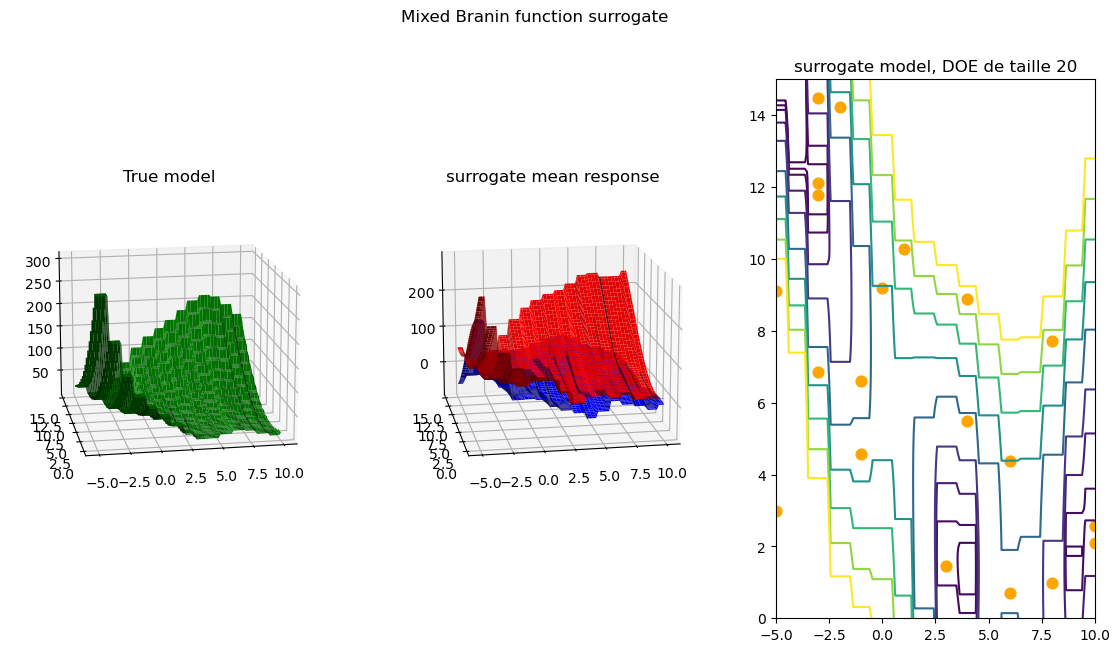

In [14]:
#to build the mixed surrogate model
sm=KRG(design_space=design_space, print_global=False, categorical_kernel=MixIntKernelType.GOWER)
sm.set_training_values(xt, yt)
sm.train()

num = 100
x = np.linspace(-5.0,10., 100)
y = np.linspace(0,15., 100)
xv, yv = np.meshgrid(x, y)
x_plot= np.array([np.ravel(xv), np.ravel(yv)]).T
y_plot = f(np.floor(x_plot))

fig = plt.figure(figsize=[14, 7])

y_gp_plot = sm.predict_values(x_plot)
y_gp_plot_sd = np.sqrt(sm.predict_variances(x_plot))
l=y_gp_plot-3*y_gp_plot_sd
h=y_gp_plot+3*y_gp_plot_sd
ax =  fig.add_subplot(1, 3, 1, projection='3d')
ax1 = fig.add_subplot(1, 3, 2, projection='3d') 
ax2 = fig.add_subplot(1, 3,3)  

ii=-100
ax.view_init(elev=15., azim=ii)
ax1.view_init(elev=15., azim=ii)

true_fun = ax.plot_surface(xv, yv, y_plot.reshape((100, 100)), label ='true_function',color='g')
data3 = ax2.scatter(xt.T[0],xt.T[1],s=60,marker="o",color="orange")
gp1 = ax1.plot_surface(xv, yv, l.reshape((100, 100)), color="b")
gp2 = ax1.plot_surface(xv, yv, h.reshape((100, 100)), color="r")  
gp3 = ax2.contour(xv, yv, y_gp_plot.reshape((100, 100)), color="k", levels=[0,1,2,5,10,20,30,40,50,60])
fig.suptitle("Mixed Branin function surrogate")
ax.set_title("True model")
ax2.set_title("surrogate model, DOE de taille {}".format(n_doe))
ax1.set_title("surrogate mean response")

- On the left, we have the real model in green.  
- In the middle we have the mean surrogate $+3\times \mbox{ standard deviation}$ (red) and the mean surrogate $-3\times \mbox{ standard deviation}$  (blue) in order to represent an approximation of the $99\%$ confidence interval.

- On the right, the contour plots of the mean surrogate are given where orange points are the values at the evaluated points (DOE).

In [15]:
#Optimization of the 2D branin function 
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xt,
    ydoe=yt,
    surrogate=sm,
    random_state=42,
)

x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=f)


In [16]:
print("Minimum in x={} with f(x)={:.1f}".format(x_opt, float(y_opt)))
print("Minimum in typed x={}".format(design_space.decode_values(x_opt)))


Minimum in x=[-3.         11.77763942] with f(x)=0.5
Minimum in typed x=[-3.0, 11.777639420895204]


Text(0.5, 1.0, 'Mixed Branin - optimization process')

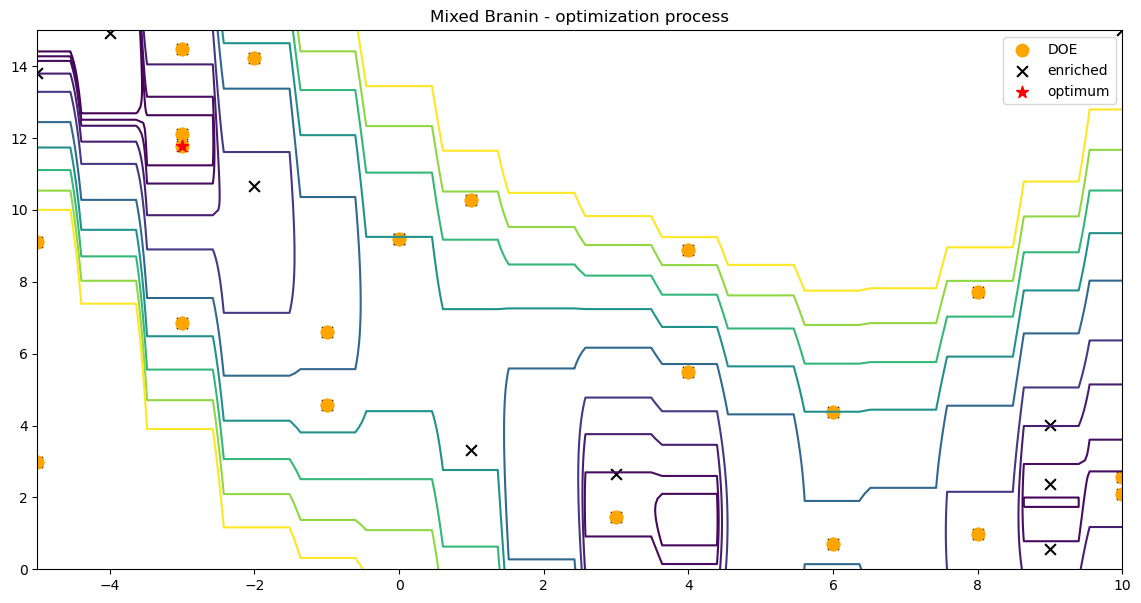

In [17]:
fig = plt.figure(figsize=[14, 7])
 
plt.scatter(xt.T[0],xt.T[1],s=80,marker="o",color="orange",label='DOE')
plt.contour(xv, yv, y_gp_plot.reshape((100, 100)), color="k", levels=[0,1,2,5,10,20,30,40,50,60])
plt.scatter(x_data.T[0],x_data.T[1],s=60,marker="x",color="black",label='enriched')
plt.scatter(xt.T[0],xt.T[1],s=80,marker="o",color="orange")
plt.scatter(x_opt[0],x_opt[1],s=80,marker="*",color="red",label='optimum')

plt.legend()

plt.title("Mixed Branin - optimization process")

## 4D mixed test case

The 4D function to optimize is described by: 
- 1 continuous variable $\in [-5, 5]$
- 1 categorical variable with 3 labels $["blue", "red", "green"]$
- 1 categorical variable with 2 labels $ ["large", "small"]$ 
- 1 discrete variable $\in [0, 2]$

Initial DOE: 
 xdoe =  [[0.48813504 1.         0.         1.        ]
 [2.15189366 1.         1.         2.        ]
 [1.02763376 1.         1.         1.        ]] 
 ydoe =  [1.97627008 6.08859796 2.95250415]


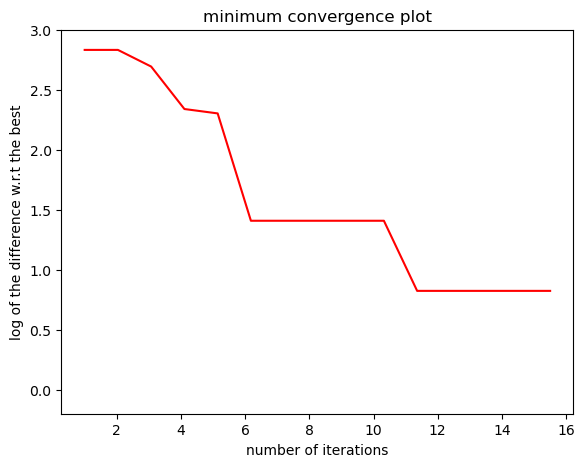

In [18]:
#to define the 4D function 
def function_test_mixed_integer(X):
    import numpy as np

    # float
    x1 = X[:, 0]
    #  enum 1
    c1 = X[:, 1]
    x2 = c1 == 0
    x3 = c1 == 1
    x4 = c1 == 2
    #  enum 2
    c2 = X[:, 2]
    x5 = c2 == 0
    x6 = c2 == 1
    # int
    i = X[:, 3]

    y = (
        (x2 + 2 * x3 + 3 * x4) * x5 * x1
        + (x2 + 2 * x3 + 3 * x4) * x6 * 0.95 * x1
        + i
    )
    return y

#to define the variables
design_space = DesignSpace ([
    FloatVariable (-5, 5),
    CategoricalVariable (["blue", "red", "green"]), #3 possible choices 
    CategoricalVariable (["large", "small"]), #2 possible choices 
    IntegerVariable (0, 2),
])

#to run the optimization process
n_iter = 15

criterion = "EI"  #'EI' or 'SBO' or 'LCB'
qEI = "KB"

sm=KRG(design_space = design_space, print_global=False, categorical_kernel=MixIntKernelType.CONT_RELAX)

n_doe = 3

sampling = MixedIntegerSamplingMethod(LHS, design_space, criterion="ese", random_state=0)
xdoe = sampling(n_doe)
ydoe = function_test_mixed_integer(xdoe)
print('Initial DOE: \n', 'xdoe = ',xdoe, '\n ydoe = ',ydoe)


ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    ydoe=ydoe,
    surrogate=sm,
    qEI=qEI,
)

x_opt,y_opt, _, _, y_data = ego.optimize(fun=function_test_mixed_integer)

#to plot the objective function during the optimization process
min_ref = -15
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.log(np.abs(np.min(y_data[0 : k + n_doe - 1]) - min_ref))
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
u = max(np.floor(max(mini)) + 1, -100)
l = max(np.floor(min(mini)) - 0.2, -10)
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(x_plot, mini, color="r")
axes.set_ylim([l, u])
plt.title("minimum convergence plot", loc="center")
plt.xlabel("number of iterations")
plt.ylabel("log of the difference w.r.t the best")
plt.show()



In [19]:
print(" 4D EGO Optimization: Minimum in x=",design_space.decode_values(x_opt), "with y value =",y_opt)

 4D EGO Optimization: Minimum in x= [-5.000000000000411, 'green', 'large', 2.0] with y value = [-13.]



## Manipulate the DOE

In [20]:
# Manipulate the DoE from integer encoding in the fold space

#to print the used DOE (integer encoding)
doe_in_integer_encoding = xdoe
print('Initial DOE in the fold space (integer encoding): ')
for i in range(n_doe):
    print("Doe point  i={} ={}".format((i), doe_in_integer_encoding[i]),'\n')

#to give the initial doe in the relaxed space from integer encoding
doe_in_one_hot_encoding = []
print('Initial DOE in the unfold space (or relaxed space) from integer encoding: ')
for i in range(n_doe):
    doe_in_one_hot_encoding.append( design_space.unfold_x(xdoe[i])[0])
    print("Doe point  i={} ={}".format((i),doe_in_one_hot_encoding[i]  ),'\n')

doe_in_enum_space = []
#to give the initial doe in the initial space from integer encoding
print('Initial DOE in the initial space (labels) from integer encoding: ')
for i in range(n_doe):
    doe_in_enum_space.append(design_space.decode_values(xdoe[i]))
    print("Doe point  i={} ={}".format((i),doe_in_enum_space[i]  ),'\n')   

Initial DOE in the fold space (integer encoding): 
Doe point  i=0 =[0.48813504 1.         0.         1.        ] 

Doe point  i=1 =[2.15189366 1.         1.         2.        ] 

Doe point  i=2 =[1.02763376 1.         1.         1.        ] 

Initial DOE in the unfold space (or relaxed space) from integer encoding: 
Doe point  i=0 =[[0.48813504 0.         1.         0.         1.         0.
  1.        ]] 

Doe point  i=1 =[[2.15189366 0.         1.         0.         0.         1.
  2.        ]] 

Doe point  i=2 =[[1.02763376 0.         1.         0.         0.         1.
  1.        ]] 

Initial DOE in the initial space (labels) from integer encoding: 
Doe point  i=0 =[0.48813503927324753, 'red', 'large', 1.0] 

Doe point  i=1 =[2.151893663724195, 'red', 'small', 2.0] 

Doe point  i=2 =[1.027633760716439, 'red', 'small', 1.0] 



In [21]:
# More manipulations to go back to integer encoding in the fold space

#to give the initial doe in the fold space from one-hot encoding
doe_in_integer_encoding =[]
print('Initial DOE in the fold space from one-hot encoding: ')
for i in range(n_doe):
    doe_in_integer_encoding.append(design_space.unfold_x(doe_in_one_hot_encoding[i])[0] )
    print("Doe point  i={} ={}".format((i),doe_in_integer_encoding[i]  ),'\n')
    




Initial DOE in the fold space from one-hot encoding: 
Doe point  i=0 =[[0.48813504 1.         0.         0.         0.         1.
  0.        ]] 

Doe point  i=1 =[[2.15189366 1.         0.         0.         0.         1.
  0.        ]] 

Doe point  i=2 =[[1.02763376 1.         0.         0.         0.         1.
  0.        ]] 



# Gower mixed based surrogate model 2D function 

The function is described by: 
- 1 continuous variable $\in [0, 4]$
- 1 categorical variable with 2 labels $["Blue", "Red"]$

For mixed integer with Gower distance, the reference thesis is available here https://eldorado.tu-dortmund.de/bitstream/2003/35773/1/Dissertation_%20Halstrup.pdf

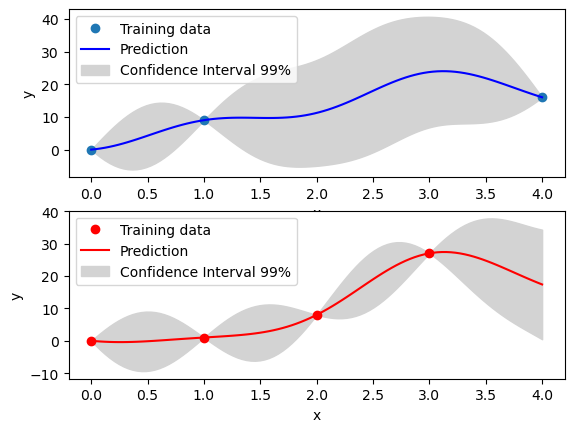

In [22]:
import numpy as np
import matplotlib.pyplot as plt


xt1 = np.array([[0,0.0],
               [0,1.0],
               [0,4.0]])
xt2 = np.array([[1,0.0],
               [1,1.0],
               [1,2.0],
               [1,3.0]])
xt = np.concatenate((xt1, xt2), axis=0)
xt[:,1] = xt[:,1].astype(np.float) 
yt1 = np.array([0.0, 9.0, 16.0])
yt2 = np.array([ 0.0, 1.0,8.0,27.0])
yt = np.concatenate((yt1, yt2), axis=0)

#to define the variables
design_space = DesignSpace ([
    CategoricalVariable (["Blue","Red"]),
    FloatVariable (0, 4),
])



# Surrogate
sm=KRG(design_space = design_space, print_global=False, categorical_kernel=MixIntKernelType.HOMO_HSPHERE)

sm.set_training_values(xt, yt)
sm.train()

# DOE for validation
n = 100
x_cat1 = []
x_cat2 = []
for i in range(n):
    x_cat1.append(0)
    x_cat2.append(1)

x_cont = np.linspace(0.0, 4.0, n)
x1 = np.concatenate((np.asarray(x_cat1).reshape(-1,1), x_cont.reshape(-1,1)), axis=1)
x2 = np.concatenate((np.asarray(x_cat2).reshape(-1,1), x_cont.reshape(-1,1)), axis=1) 

y1 = sm.predict_values(x1)
y2 = sm.predict_values(x2)

# estimated variance
s2_1 = sm.predict_variances(x1)
s2_2 = sm.predict_variances(x2)

fig, axs = plt.subplots(2)
axs[0].plot(xt1[:,1].astype(np.float), yt1,'o',linestyle="None")
axs[0].plot(x_cont, y1,color ='Blue')
axs[0].fill_between(
    np.ravel(x_cont),
    np.ravel(y1 - 3 * np.sqrt(s2_1)),
    np.ravel(y1 + 3 * np.sqrt(s2_1)),
    color="lightgrey",
)
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].legend(
    ["Training data", "Prediction", "Confidence Interval 99%"],
    loc="upper left",
)
axs[1].plot(xt2[:,1].astype(np.float), yt2, marker='o', color='r',linestyle="None")
axs[1].plot(x_cont, y2,color ='Red')
axs[1].fill_between(
    np.ravel(x_cont),
    np.ravel(y2 - 3 * np.sqrt(s2_2)),
    np.ravel(y2 + 3 * np.sqrt(s2_2)),
    color="lightgrey",
)
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].legend(
    ["Training data", "Prediction", "Confidence Interval 99%"],
    loc="upper left",
)

plt.show()  



## Gower mixed based optimization 4D function 

In [23]:
#to define the 4D function 
def function_test_mixed_integer(X):
    import numpy as np

    # float
    x1 = X[:, 3]
    #  enum 1
    c1 = X[:, 0]
    x2 = c1 == 0
    x3 = c1 == 1
    x4 = c1 == 2
    #  enum 2
    c2 = X[:, 1]
    x5 = c2 == 0
    x6 = c2 == 1
    # int
    i = X[:, 2]

    y = (
        (x2 + 2 * x3 + 3 * x4) * x5 * x1
        + (x2 + 2 * x3 + 3 * x4) * x6 * 0.95 * x1
        + i
    )
    return y
#to define the variables
design_space = DesignSpace ([
    CategoricalVariable (["blue", "red", "green"]),
    CategoricalVariable (["large", "small"]),
    OrdinalVariable(["0", "1", "2"]),
    FloatVariable (-5, 5),
])

#to run the optimization process
n_iter = 20
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
qEI = "KB"

sm=KRG(design_space = design_space, print_global=False, categorical_kernel=MixIntKernelType.GOWER)

n_doe = 2
sampling = MixedIntegerSamplingMethod(LHS, design_space, criterion="ese", random_state=0)
xdoe = sampling(n_doe)
ydoe = function_test_mixed_integer(xdoe)
print('Initial DOE: \n', 'xdoe = ',xdoe, '\n ydoe = ',ydoe)

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    ydoe=ydoe,
    surrogate=sm,
    qEI=qEI,
    verbose=True,
)

x_opt,y_opt, _, _, y_data = ego.optimize(fun=function_test_mixed_integer)

print(x_opt,y_opt)

Initial DOE: 
 xdoe =  [[ 1.          1.          1.         -1.15618293]
 [ 2.          1.          1.         -2.02465393]] 
 ydoe =  [-1.19674756 -4.77026371]
Initial DOE given
Internal optimization succeeded at EGO iter = 0.0
Internal optimization succeeded at EGO iter = 1.0
Internal optimization succeeded at EGO iter = 2.0
Internal optimization succeeded at EGO iter = 3.0
Internal optimization succeeded at EGO iter = 4.0
Internal optimization succeeded at EGO iter = 5.0
Internal optimization succeeded at EGO iter = 6.0
Internal optimization succeeded at EGO iter = 7.0
Internal optimization succeeded at EGO iter = 8.0
Internal optimization succeeded at EGO iter = 9.0
Internal optimization succeeded at EGO iter = 10.0
Internal optimization succeeded at EGO iter = 11.0
Internal optimization succeeded at EGO iter = 12.0
Internal optimization succeeded at EGO iter = 13.0
Internal optimization succeeded at EGO iter = 14.0
Internal optimization succeeded at EGO iter = 15.0
Internal optim

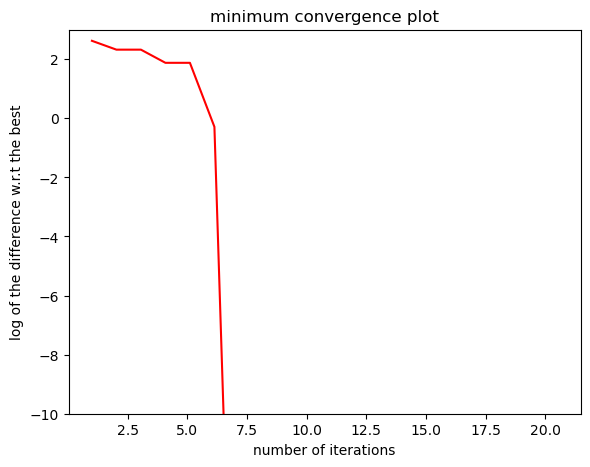

In [24]:
#to plot the objective function during the optimization process
min_ref = -15
mini = np.zeros(n_iter)
for k in range(n_iter):
    if np.abs(np.min(y_data[0 : k + n_doe - 1]) - min_ref) == 0.0 :
           mini[k]=0
    else:
        mini[k] = np.log(np.abs(np.min(y_data[0 : k + n_doe - 1]) - min_ref))
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
u = max(np.floor(max(mini)) + 1, -100)
l = max(np.floor(min(mini)) - 0.2, -10)
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(x_plot, mini, color="r")
axes.set_ylim([l, u])
plt.title("minimum convergence plot", loc="center")
plt.xlabel("number of iterations")
plt.ylabel("log of the difference w.r.t the best")
plt.show()

In [25]:
print(" 4D EGO Optimization: Minimum in x=", design_space.decode_values(x_opt), "with y value =",y_opt)

 4D EGO Optimization: Minimum in x= ['green', 'large', '0', -5.000000000001229] with y value = [-15.]


# Group kernel mixed based optimization 4D function 

There are two distinct models: the homoscedastic one (HOMO_GAUSSIAN) that does not considerer different variances between the variables and the heteroscedastic one (HETERO_GAUSSIAN).

For mixed integer with Group kernels, the reference thesis is available here https://hal.inria.fr/tel-03113542/document

Initial DOE: 
 xdoe =  [[ 1.          1.          1.         -1.15618293]
 [ 2.          1.          1.         -2.02465393]] 
 ydoe =  [-1.19674756 -4.77026371]


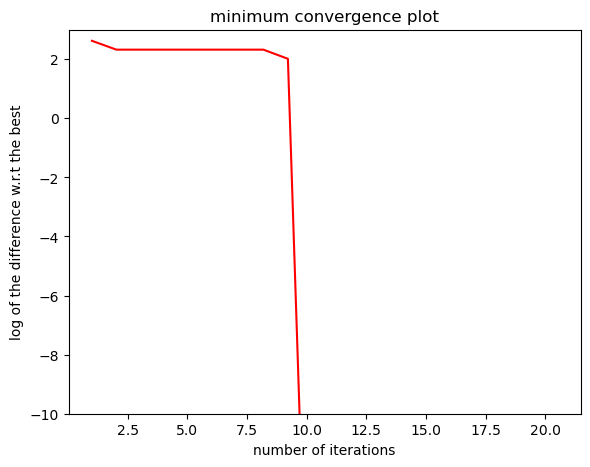

In [26]:
#to define the 4D function 
def function_test_mixed_integer(X):
    import numpy as np

    # float
    x1 = X[:, 3]
    #  enum 1
    c1 = X[:, 0]
    x2 = c1 == 0
    x3 = c1 == 1
    x4 = c1 == 2
    #  enum 2
    c2 = X[:, 1]
    x5 = c2 == 0
    x6 = c2 == 1
    # int
    i = X[:, 2]

    y = (
        (x2 + 2 * x3 + 3 * x4) * x5 * x1
        + (x2 + 2 * x3 + 3 * x4) * x6 * 0.95 * x1
        + i
    )
    return y
#to define the variables
design_space = DesignSpace ([
    CategoricalVariable (["blue", "red", "green"]),
    CategoricalVariable (["large", "small"]),
    OrdinalVariable(["0", "1", "2"]),
    FloatVariable (-5, 5),
])

#to run the optimization process
n_iter = 20
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
qEI = "KB"

sm=KRG(design_space = design_space, print_global=False, 
       categorical_kernel=MixIntKernelType.HOMO_HSPHERE)

n_doe = 2
sampling = MixedIntegerSamplingMethod(LHS, design_space, criterion="ese", random_state=0)
xdoe = sampling(n_doe)
ydoe = function_test_mixed_integer(xdoe)
print('Initial DOE: \n', 'xdoe = ',xdoe, '\n ydoe = ',ydoe)

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    ydoe=ydoe,
    surrogate=sm,
    qEI=qEI,
)

x_opt,y_opt, _, _, y_data = ego.optimize(fun=function_test_mixed_integer)

#to plot the objective function during the optimization process
min_ref = -15
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.log(np.abs(np.min(y_data[0 : k + n_doe - 1]) - min_ref))
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
u = max(np.floor(max(mini)) + 1, -100)
l = max(np.floor(min(mini)) - 0.2, -10)
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(x_plot, mini, color="r")
axes.set_ylim([l, u])
plt.title("minimum convergence plot", loc="center")
plt.xlabel("number of iterations")
plt.ylabel("log of the difference w.r.t the best")
plt.show()



In [27]:
print(" 4D EGO Optimization: Minimum in x=",design_space.decode_values(x_opt), "with y value =",y_opt)

 4D EGO Optimization: Minimum in x= ['green', 'large', '0', -5.000000000026851] with y value = [-15.]
